In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import scipy as sp
import pywt
from sklearn.model_selection import GroupKFold
import pickle 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#用来计算程序运行时间
import datetime
starttime = datetime.datetime.now()

In [2]:
#读取32个通道的EEG数据，每个通道包含32×40=1280个信号样本（人次×每人次40实验）
#每个样本向量大小为8064点（63s*128Hz）
for eeg_CH in range(1,33,1):
    file_path = "./dump_file/CH{}_df_EEG_x".format(eeg_CH)
    locals()['CH{}_df_EEG_x'.format(eeg_CH)] = pickle.load(open(file_path,"rb"))

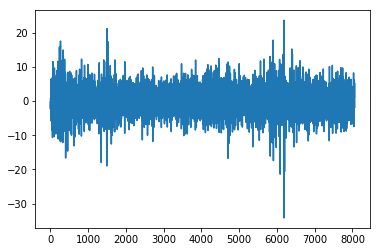

In [3]:
#画某个信号波形
plt.plot(CH10_df_EEG_x.iloc[0,:])
plt.show()

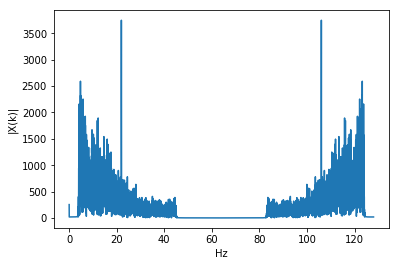

In [4]:
#EEG DFT(FFT)频域数据
def eegFFT(df_data):
    eegfft_df = pd.DataFrame()
    for i in df_data.index.tolist():
        temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
        temp_eegfft.index = [i]
        eegfft_df = eegfft_df.append(temp_eegfft)
    return eegfft_df

df = eegFFT(CH1_df_EEG_x)
fft_abs = abs(df.iloc[1,:])
X = [(n-1)*128/8064 for n in range(1,8065,1) ]
plt.plot(X,fft_abs)
plt.xlabel("Hz")
plt.ylabel("|X(k)|")
#plt.title(u'某个EEG信号的频谱',fontproperties='SimHei')
plt.show()


In [5]:
#多进程运行的函数
def runFFT(eegCH,startPoint,endPoint):
    ############################################################################
    #EEG DFT(FFT)频域数据    
    starttime = datetime.datetime.now()
    def eegFFT(df_data):
        eegfft_df = pd.DataFrame()
        for i in df_data.index.tolist():
            temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
            temp_eegfft.index = [i]
            eegfft_df = eegfft_df.append(temp_eegfft)
        return eegfft_df
    file_path = "./dump_file/CH{}_df_EEG_x".format(eegCH)
    locals()['CH{}_df_EEG_x'.format(eegCH)] = pickle.load(open(file_path,"rb"))
    ############################################################################   
    file_path = "./dump_file/CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)
    df = eegFFT(locals()['CH{}_df_EEG_x'.format(eegCH)].iloc[:,startPoint:endPoint])
    locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)] = df
    pickle.dump(locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)],open(file_path,"wb"))
    #用来计算程序运行时间
    endtime = datetime.datetime.now()
    print("程序运行时间（多进程）p%d:%.1fs"%(eegCH,(endtime - starttime).seconds))

          
#多进程编程 
startPoint = int((8064/63)*20)
endPoint = int((8064/63)*63)
if False:
    for eegCH in range(1,33,1):
        locals()["p{}".format(eegCH)] = multiprocessing.Process(target = runFFT, args = (eegCH,startPoint,endPoint))
        locals()["p{}".format(eegCH)].start()
        print("p{}.pid:{}".format(eegCH,locals()["p{}".format(eegCH)].pid))
else:
    for eegCH in range(1,33,1):
        #file_path = "./dump_file/CH{}eegfft_df".format(eeg_CH)
        file_path = "./dump_file/CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)
        locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)] = pickle.load(open(file_path,"rb"))

#把不同时间范围的FFT文件做同一处理
for eegCH in range(1,33,1):
    locals()["CH{}eegfft_df".format(eegCH)] = locals()["CH{}eegfft_df_{}_{}".format(eegCH,startPoint,endPoint)]

- 将脑电分为5个带，每个通带计算功率谱特征
- delta 1-4Hz
- theta 4-8Hz
- alpha 8-14Hz
- beta  14-30Hz
- gamma 30-47Hz
- 巴特沃兹带通滤波器提取相应频带特征 
- |
- FFT到频域计算各频带的能量作为特征$b_{band}=\sum_{k=1}^N{|X_i(k)|^2}$

In [6]:
#sp.signal.butter(4,,btype='bandpass',analog=False, )


- FFT运算比较费时间，如果不是第一次运算，则直接读取dump的文件即可

In [7]:
'''
#用来计算频率的分割点
starttime = datetime.datetime.now()
def countFerqHz(n):
    return (n-1)*128/8064
for n in range(1,8065,1):
    if countFerqHz(n)<4 and countFerqHz(n+1)>=4:
        print("theta_low_n:%d"%(n+1))
    if countFerqHz(n)<8 and countFerqHz(n+1)>=8:
        print("theta_high_n:%d"%(n))
        print("alpha_low_n:%d"%(n+1))
    if countFerqHz(n)<14 and countFerqHz(n+1)>=14:
        print("alpha_high_n:%d"%(n))
        print("beta_low_n:%d"%(n+1))
    if countFerqHz(n)<30 and countFerqHz(n+1)>=30:
        print("beta_high_n:%d"%(n))
        print("gamma_low_n:%d"%(n+1))
    if countFerqHz(n)<47 and countFerqHz(n+1)>=47:
        print("gamma_high_n:%d"%(n))
        
#用来计算程序运行时间
endtime = datetime.datetime.now()
print("程序运行时间:%.1fs"%(endtime - starttime).seconds)
'''
#theta:[253,504]
#alpha:[505,882]
#beta:[883,1890]
#gamma:[1891,2961]

'\n#用来计算频率的分割点\nstarttime = datetime.datetime.now()\ndef countFerqHz(n):\n    return (n-1)*128/8064\nfor n in range(1,8065,1):\n    if countFerqHz(n)<4 and countFerqHz(n+1)>=4:\n        print("theta_low_n:%d"%(n+1))\n    if countFerqHz(n)<8 and countFerqHz(n+1)>=8:\n        print("theta_high_n:%d"%(n))\n        print("alpha_low_n:%d"%(n+1))\n    if countFerqHz(n)<14 and countFerqHz(n+1)>=14:\n        print("alpha_high_n:%d"%(n))\n        print("beta_low_n:%d"%(n+1))\n    if countFerqHz(n)<30 and countFerqHz(n+1)>=30:\n        print("beta_high_n:%d"%(n))\n        print("gamma_low_n:%d"%(n+1))\n    if countFerqHz(n)<47 and countFerqHz(n+1)>=47:\n        print("gamma_high_n:%d"%(n))\n        \n#用来计算程序运行时间\nendtime = datetime.datetime.now()\nprint("程序运行时间:%.1fs"%(endtime - starttime).seconds)\n'

In [8]:
def countPower(N,df):
    return np.square(abs(df)).sum(axis=1)
        
eegFeatureDF = pd.DataFrame()
for eegCH in range(1,33,1):
    '''E_band特征'''
    powerTheta = countPower(504-253+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,253:504+1])
    powerAlpha = countPower(882-505+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,505:882+1])
    powerBeta = countPower(1890-883+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,883:1890+1])
    powerGamma = countPower(2961-1891+1,locals()["CH{}eegfft_df".format(eegCH)].iloc[:,1891:2961+1])
    powerThetaDF = pd.DataFrame(powerTheta,columns=["CH{}ThetaPower".format(eegCH)])   
    powerAlphaDF = pd.DataFrame(powerAlpha,columns=["CH{}AlphaPower".format(eegCH)])   
    powerBetaDF = pd.DataFrame(powerBeta,columns=["CH{}BetaPower".format(eegCH)])    
    powerGammaDF = pd.DataFrame(powerGamma,columns=["CH{}GammaPower".format(eegCH)])
    '''E_RPE特征,相对能量特征(Relative Power Energy,RPE)'''
    powerTotal = powerTheta + powerAlpha + powerBeta + powerGamma
    E_RPE_Theta = powerTheta / powerTotal
    E_RPE_Alpha = powerAlpha / powerTotal
    E_RPE_Beta = powerBeta / powerTotal
    E_RPE_Gamma = powerGamma / powerTotal
    E_RPE_ThetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Theta".format(eegCH)])
    E_RPE_AlphaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Alpha".format(eegCH)])
    E_RPE_BetaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Beta".format(eegCH)])
    E_RPE_GammaDF = pd.DataFrame(E_RPE_Theta,columns=["CH{}E_RPE_Gamma".format(eegCH)])
    '''E_LRPE特征,对数相对能量特征(Logarithmic Relative Power Energy,LRPE)'''
    E_LRPE_Theta = np.log(E_RPE_Theta)
    E_LRPE_Alpha = np.log(E_RPE_Alpha)
    E_LRPE_Beta = np.log(E_RPE_Beta)
    E_LRPE_Gamma = np.log(E_RPE_Gamma)
    E_LRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Theta".format(eegCH)])
    E_LRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Alpha".format(eegCH)])
    E_LRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Beta".format(eegCH)])
    E_LRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_LRPE_Gamma".format(eegCH)])
    '''E_ALRPE特征,对数绝对值相对能量特征(Absolute Logarithmic Relative Power Energy,ALRPE)'''
    E_ALRPE_Theta = abs(E_LRPE_Theta)
    E_ALRPE_Alpha = abs(E_LRPE_Alpha)
    E_ALRPE_Beta = abs(E_LRPE_Beta) 
    E_ALRPE_Gamma = abs(E_LRPE_Gamma)
    E_ALRPE_ThetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Theta".format(eegCH)])
    E_ALRPE_AlphaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Alpha".format(eegCH)])
    E_ALRPE_BetaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Beta".format(eegCH)])
    E_ALRPE_GammaDF = pd.DataFrame(E_LRPE_Theta,columns=["CH{}E_ALRPE_Gamma".format(eegCH)])
    concatList = [eegFeatureDF,powerThetaDF,powerAlphaDF,powerBetaDF,powerGammaDF,
                  E_RPE_ThetaDF,E_RPE_AlphaDF,E_RPE_BetaDF,E_RPE_GammaDF,
                  E_LRPE_ThetaDF,E_LRPE_AlphaDF,E_LRPE_BetaDF,E_LRPE_GammaDF,
                  E_ALRPE_ThetaDF,E_ALRPE_AlphaDF,E_ALRPE_BetaDF,E_ALRPE_GammaDF,]
    eegFeatureDF = pd.concat(concatList,axis=1)


In [9]:
#coef, freqs = pywt.cwt(CH10_df_EEG_x.iloc[0,:],np.arange(1,5000),'gaus1')
#plt.matshow(coef) 
#plt.show()
'''
sig = CH1_df_EEG_x.iloc[0,:].values
widths = np.arange(1, 128)
cwtmatr, freqs = pywt.cwt(sig, widths, 'bior2.8')
plt.imshow(cwtmatr, extent=[0, 63, 1, 128], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.show() 
'''

"\nsig = CH1_df_EEG_x.iloc[0,:].values\nwidths = np.arange(1, 128)\ncwtmatr, freqs = pywt.cwt(sig, widths, 'bior2.8')\nplt.imshow(cwtmatr, extent=[0, 63, 1, 128], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  \nplt.show() \n"

In [10]:
wavlist = pywt.wavelist(kind='all')
print(wavlist)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

In [11]:
print(eegFeatureDF.shape)
#dump到文件保存
pickle.dump(eegFeatureDF,open("./dump_file/eegFeatureDF","wb")) 


(1280, 512)
